# LiDAR Uncertainty: A Comparison of Two California Sites.

## The Soap Site
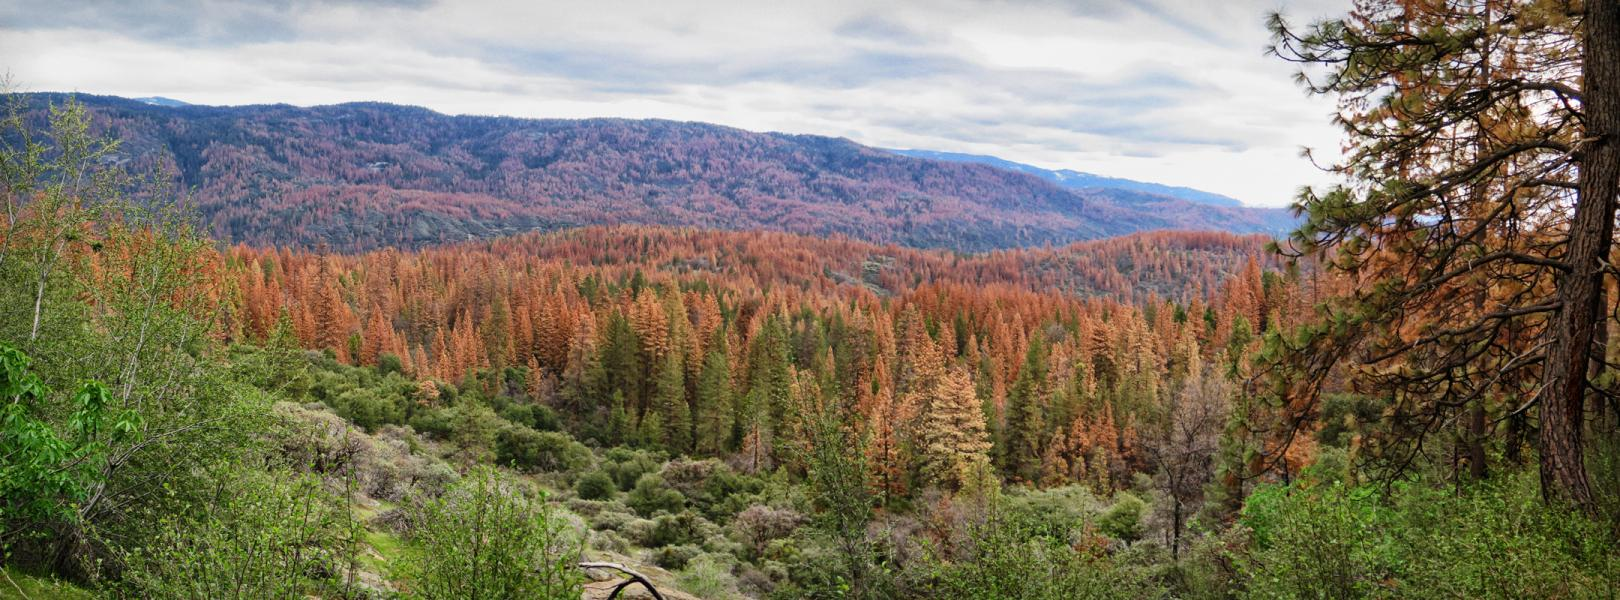
image credit: National Ecological Observation Network

## The SJER Site
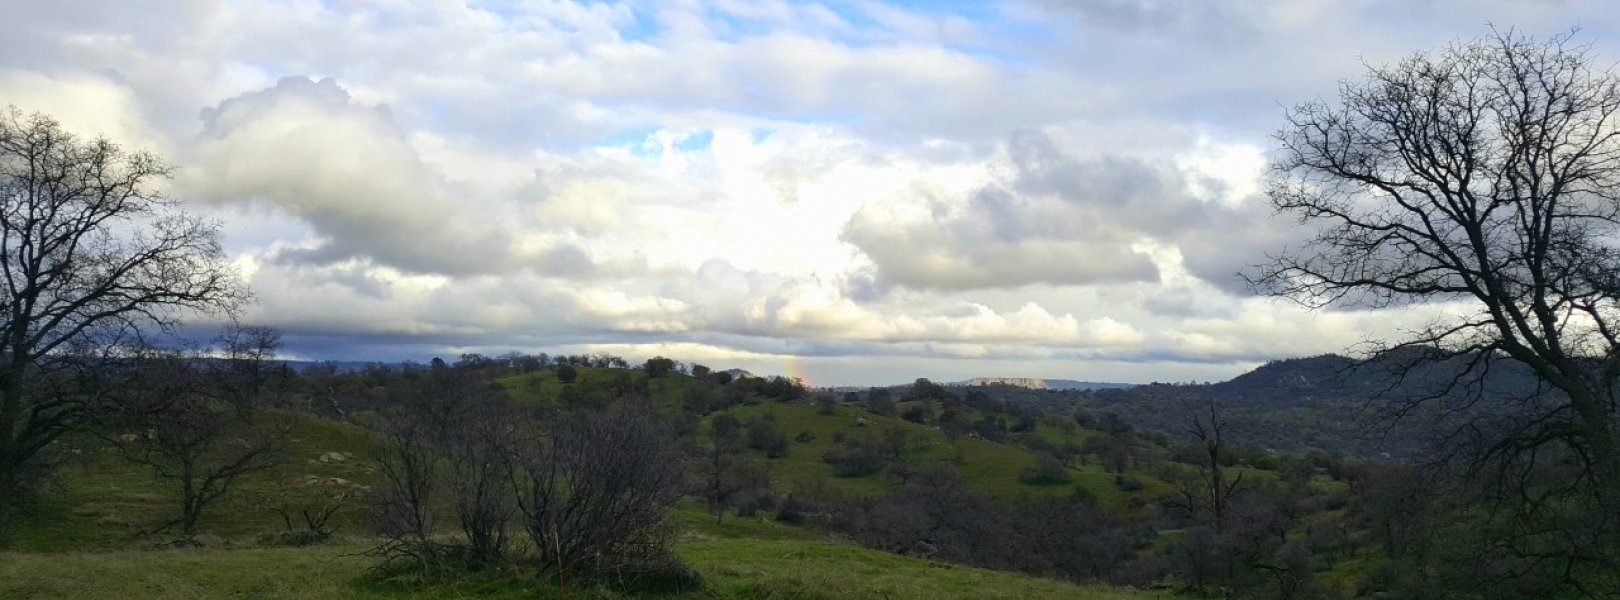
image credit: National Ecological Observation Network

In [7]:
# Import necessary packages
import os
import pathlib

import clean_text2
import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterstats as rs
import rioxarray as rxr
import xarray as xr
import seaborn as sns

# Download data from earth py
et.data.get_data('spatial-vector-lidar')

# General housekeeping
home_dir = os.path.join(pathlib.Path.home(), 'earth-analytics',
                        'data', 'spatial-vector-lidar')
os.chdir(home_dir)

# If the dir does not exist, create it
output_path = os.path.join(home_dir,
                           "outputs")

In [18]:
class NEONDataLoader:
    
    '''This class creates all of our necessary paths for downloads
    
    parameters:
    ----------
    site_name = str
    id_col = str
    formatting_dict = key (?)
    
    returns:
    -------
    Data is opened and transferred to correct locations.
    '''
    
    # Create necessary variables for SOAP and SJER sites.
    base_dir_tmpl = os.path.join('california',
                                     'neon-{site_name_low}-site')

    insitu_path_tmpl = os.path.join('{base_dir}', '2013',
                                        'insitu', 'veg{separator}structure',
                                        'D17_2013_{site_name_up}_vegStr.csv')
    plots_path_tmpl = os.path.join(
            '{base_dir}', 'vector_data', '{site_name_up}{plot}_centroids.shp')
    chm_path_tmpl = os.path.join(
            '{base_dir}', '2013', 'lidar', '{site_name_up}_lidarCHM.tif')
        
    def __init__(self, site_name, id_col, formatting_dict={}):
        self.site_name = site_name
        self.id_col = id_col
        self.formatting_dict = formatting_dict
        self.formatting_dict['site_name_low'] = site_name.lower()
        self.formatting_dict['site_name_up'] = site_name.upper()
        self.formatting_dict['base_dir'] = self.base_dir_tmpl.format(**self.formatting_dict)
        
        self.insitu_path=self.insitu_path_tmpl.format(**self.formatting_dict)
        self.plots_path=self.plots_path_tmpl.format(**self.formatting_dict)
        self.chm_path=self.chm_path_tmpl.format(**self.formatting_dict)

In [19]:
sjer_data_loader = NEONDataLoader('SJER', 'Plot_ID',
                                  {'separator': '_', 'plot': '_plot'})
sjer_data_loader

In [20]:
soap_data_loader=NEONDataLoader('SOAP', 'ID', {'separator':'-', 'plot':''})
soap_data_loader.insitu_path

'california\\neon-soap-site\\2013\\insitu\\veg-structure\\D17_2013_SOAP_vegStr.csv'

In [59]:
class AnalyzeLidarUncertainty:

    '''This class calculates stats for lidar and insitu and merges the two data frames.
    
        parameters:
        ----------
        lidar_path: str (or path?) 
        insitu_path: str
        plots_path: str
        
        returns:
        -------
        Processed data frame.
        
        '''

    def __init__(self, lidar_path, insitu_path, plots_path):
        self.lidar_path = lidar_path
        self.insitu_path = insitu_path
        self.plots_path = plots_path

    def calc_lidar_chm_stats(self):
        
        '''
        Calculates lidar mean and max tree heights.
        '''
        
        lidar_chm = rxr.open_rasterio(
            self.lidar_path, masked=True).squeeze()
        lidar_chm_clean = lidar_chm.where(lidar_chm > 0, np.nan)

        plots_gdf = gpd.read_file(self.plots_path)
        plots_gdf.geometry = plots_gdf.geometry.buffer(20)

        lidar_chm_stats = rs.zonal_stats(
            plots_gdf,
            lidar_chm_clean.values,
            affine=lidar_chm_clean.rio.transform(),
            nodata=-999,
            geojson_out=True,
            copy_properties=True,
            stats='count mean max')

        # Create a gdf based on the stats requested from zonal stats and rename columns.
        lidar_chm_gdf = gpd.GeoDataFrame.from_features(lidar_chm_stats)

        lidar_chm_gdf.rename(
            columns={'max': 'lidar_max',
                     'mean': 'lidar_mean'},
            inplace=True)
        
        
        return lidar_chm_gdf

    def calc_insitu_dfs(self):
        
        '''
        Calculate insitu tree height mean and max.
        '''
        
        df = (pd.read_csv(self.insitu_path)
              .groupby('plotid')
              .stemheight
              .agg(['max', 'mean'])
              .rename(columns={'max': 'insitu_max', 'mean': 'insitu_mean'}))
        
        return df
    
    def merge_dfs(self): #id_col='Plot_ID'):
        
        '''
        Merges insitu and lidar data frames together.
        
        '''
        
        chm_stats_gdf = self.calc_lidar_chm_stats()
        insitu_height_df = self.calc_insitu_dfs()
        
        study_site= {''}
        ss = 'SOAP'

        chm_stats_gdf['Plot_ID'] = ss + chm_stats_gdf['Plot_ID']


        if (study_site == 'soap'):
            ss = study_site.upper()
            chm_stats_gdf['Plot_ID'] = ss + chm_stats_gdf['Plot_ID']
            
        
        data_frame = chm_stats_gdf.merge(
            insitu_height_df, right_index=True, left_on=id_col)
        
        return data_frame


sjer_site = AnalyzeLidarUncertainty(sjer_data_loader.chm_path, sjer_data_loader.insitu_path, sjer_data_loader.plots_path )
sjer_site.calc_lidar_chm_stats()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,count
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,161
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,443
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,643
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,245
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,17
5,"POLYGON ((257098.867 4111388.570, 257098.771 4...",SJER128,center,4111388.570,257078.867,trees,19.139999,8.987087,381
6,"POLYGON ((256703.434 4111071.087, 256703.338 4...",SJER192,center,4111071.087,256683.434,grass,16.549999,7.229096,929
7,"POLYGON ((256737.467 4112167.778, 256737.371 4...",SJER272,center,4112167.778,256717.467,trees,11.840000,7.107061,711
8,"POLYGON ((256054.390 4111533.879, 256054.294 4...",SJER2796,center,4111533.879,256034.390,soil,20.279999,6.409630,270
9,"POLYGON ((258517.102 4109856.983, 258517.006 4...",SJER3239,center,4109856.983,258497.102,soil,12.910000,6.009128,195


In [61]:
soap_site = AnalyzeLidarUncertainty(soap_data_loader.chm_path, soap_data_loader.insitu_path, soap_data_loader.plots_path)
print(soap_site.merge_dfs())



KeyError: 'Plot_ID'

In [47]:
def plot_regression(df):

    # Plot SJER data with regression lines/scatterplot.
    fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,12))
    fig.suptitle(
        '{} Insitu & Lidar Comparison', fontsize=14)
    ax1.scatter(df.lidar_mean, df.insitu_mean)
    ax1.set(xlim=(0,30), ylim=(0,30), aspect='equal', title='Mean Values')
    sns.regplot('lidar_mean', 'insitu_mean',
               data=df,
               color='purple',
               ax=ax1)
    ax1.plot((0,1),(0,1), transform=ax1.transAxes, ls='--', c='k')

    ax2.scatter(df.lidar_max, df.insitu_max)
    ax2.set(xlim=(0,30), ylim=(0,30), aspect='equal', title='Max Values')
    sns.regplot('lidar_max', 'insitu_max', 
                data=df, 
                color='purple', 
                ax=ax2)
    ax2.plot((0,1),(0,1), transform=ax2.transAxes, ls='--', c='k')
    return regression_plot

plot_regression(soap_site.merge_dfs())

KeyError: 'Plot_ID'